### optuna で得た lr で学習させる、CP使ってモデルを保存する

In [2]:
import os
import re
import datetime
import random
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')


def generate_data(x, t, num=5):
  datagen = ImageDataGenerator(
    #rotation_range=180,     # randomly rotate images in the range
    zoom_range=0.2,         # randomly zoom image
    width_shift_range=0.2,  # randomly shift images horizontally
    height_shift_range=0.2, # randomly shift images vertically
    horizontal_flip=True,   # randomly flip images horizontally
    #vertical_flip=True      # randomly flip images vertically
  )

  x_list = []
  t_list = []

  x_array = np.expand_dims(x, axis=0)

  datagen.fit(x_array)

  iter = datagen.flow(x_array, batch_size=1)

  for i in range(num):
    ret = iter.next()
    #print(ret.shape, ret.dtype)
    x_list.append(ret[0])
    t_list.append(t)

  return x_list, t_list


def prepare_data(gen_num=5):
  x, t = [], []

  categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

  for dir_path in categorized_dir_paths:
    category_id = os.path.basename(dir_path)
    image_paths = glob(os.path.join(dir_path, '*'))
    print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

    for i, p in enumerate(image_paths):
      book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

      if i % 30 == 0:
          print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

      try:
          img = Image.open(p)
          img_resize = img.resize((229, 229))
          img_np = np.array(img_resize) / 255.0

          x.append(img_np)
          t.append(category_id)

          x_gen, t_gen = generate_data(img_np, category_id, gen_num)
          x.extend(x_gen)
          t.extend(t_gen)

      except Exception as e:
          print(datetime.datetime.now().isoformat(), 'Error:', e)

  return x, t


def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

reset_seed(0)


x, t = prepare_data(5)
print(len(x), len(t))

x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)
print(x_train.shape, x_val.shape)

category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-06-23T08:14:23.644679 Category 0 : 117
2020-06-23T08:14:23.645969 Image: 0 1015 0
2020-06-23T08:14:36.315302 Image: 30 1228 0
2020-06-23T08:14:48.997451 Image: 60 1106 0
2020-06-23T08:15:02.028058 Image: 90 1129 0
2020-06-23T08:15:12.495877 Category 1 : 119
2020-06-23T08:15:12.496789 Image: 0 3636 1
2020-06-23T08:15:24.780371 Image: 30 3722 1
2020-06-23T08:15:41.736958 Image: 60 3832 1
2020-06-23T08:15:53.539202 Image: 90 3777 1
2020-06-23T08:16:05.314412 Category 2 : 129
2020-06-23T08:16:05.315823 Image: 0 3601 2
2020-06-23T08:16:17.886727 Image: 30 3884 2
2020-06-23T08:16:31.482906 Image: 60 3778 2
2020-06-23T08:16:42.969467 Image: 90 3853 2
2020-06-23T08:16:53.954299 Image: 120 1502 2
2020-06-23T08:16:57.430215 Category 3 : 111
2020-06-23T08:16:57.431340 Image: 0 3312 3
2020-06-23T08:17:09.276309 Image: 30 2350 3
2020-06-23T08:17:23.256335 Image: 60 3

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5',
                             monitor='val_acc',
                             mode='max',
                             save_best_only=True,
                             #include_optimizer=False, # Unsupported?
                             save_weights_only=False,
                             save_fre=1, # period is deprecated
                             verbose=1)

In [14]:
def create_model():
  model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])
  
  for layer in model_fine.layers[:100]:
      layer.trainable = False
  
  model = models.Sequential()
  model.add(model_fine)
  
  model.add(layers.Flatten())
  
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(category_count, activation='softmax'))
  
  optimizer = keras.optimizers.Adagrad(lr=0.004705)
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

2020-06-23T08:35:39.860059 Start

Epoch 00001: val_accuracy improved from -inf to 0.27655, saving model to /content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5

Epoch 00002: val_accuracy did not improve from 0.27655

Epoch 00003: val_accuracy improved from 0.27655 to 0.29872, saving model to /content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5

Epoch 00004: val_accuracy improved from 0.29872 to 0.38506, saving model to /content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5

Epoch 00005: val_accuracy improved from 0.38506 to 0.58226, saving model to /content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5
2020-06-23T08:38:50.171602 End


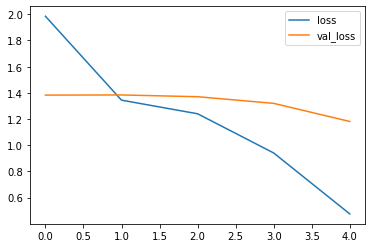

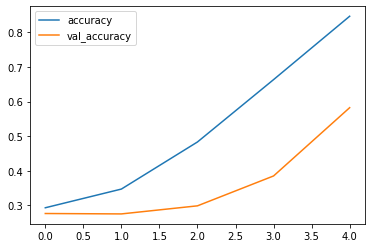

In [15]:
print(datetime.datetime.now().isoformat(), 'Start')

model = create_model()

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=5,
    verbose=0,
    validation_data=(x_val, t_val),
    callbacks=[checkpoint]
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

2020-06-23T08:41:46.469859 Start

Epoch 00001: val_accuracy improved from 0.58226 to 0.64411, saving model to /content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5

Epoch 00002: val_accuracy improved from 0.64411 to 0.74796, saving model to /content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5

Epoch 00003: val_accuracy improved from 0.74796 to 0.78530, saving model to /content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5

Epoch 00004: val_accuracy improved from 0.78530 to 0.81447, saving model to /content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5

Epoch 00005: val_accuracy did not improve from 0.81447
2020-06-23T08:44:48.650427 End


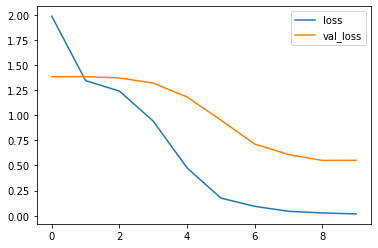

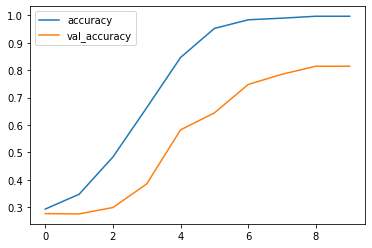

In [16]:
print(datetime.datetime.now().isoformat(), 'Start')

#model = create_model()

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=5,
    verbose=0,
    validation_data=(x_val, t_val),
    callbacks=[checkpoint]
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [17]:
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/kikagaku/novelapp/category-2_model21.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             #include_optimizer=False, # Unsupported?
                             save_weights_only=False,
                             save_fre=1, # period is deprecated
                             verbose=0)

2020-06-23T08:46:27.933689 Start
2020-06-23T09:39:11.907709 End


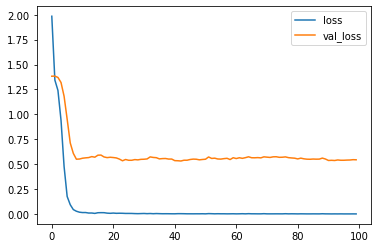

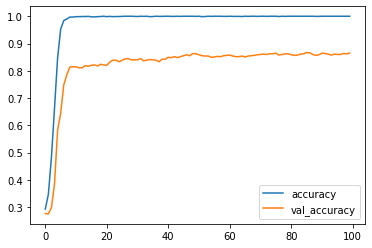

In [18]:
print(datetime.datetime.now().isoformat(), 'Start')

#model = create_model()

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=90,
    verbose=0,
    validation_data=(x_val, t_val),
    callbacks=[checkpoint]
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [ ]:
print(datetime.datetime.now().isoformat(), 'Start')

#model = create_model()

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=900,
    verbose=0,
    validation_data=(x_val, t_val),
    callbacks=[checkpoint]
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

2020-06-23T09:48:41.483115 Start
